In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

In [3]:
# Load the Pre-Trained ResNet Model
vgg_cnn = models.vgg19(weights=models.VGG19_Weights)
vgg_cnn.eval()

c:\Users\arham\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
img_transform = transforms.Compose([
    # Convert the image into a tensor and perform normalization.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
class ReadDataCSV(Dataset):
    def __init__(self, csv_file_path, train=True, transform=None):
        data = pd.read_csv(csv_file_path)

        # Raw data extracted from csv file
        raw = data.to_numpy
        # Get the number of images in the CSV file
        num_images = data.shape[0]
        # All images stored as an array of pixels
        image_as_array = data.values[:,1:]
        # Labels from 1-18. One for each class. Each class represents a different family of fish.
        label_as_array = data.values[:,0]
        # Reshape the row of pixels into a 150x150x3 RGB image
        self.images_numpy = image_as_array.reshape(num_images, 150, 150, 3)
        self.targets = label_as_array
        self.transform = transform
    
    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        # Get the specific image and label from the array
        img, target = self.images_numpy[index], self.targets[index]
        img = img.squeeze().astype(np.uint8)
        img = Image.fromarray(img)

        # Perform image transformation (normalization)
        if self.transform is not None:
            img = self.transform(img)
        # Convert the target label into a tensor
        target = torch.tensor(target)
        return img, target

In [6]:
dataset = ReadDataCSV("test_data.csv",transform=img_transform)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


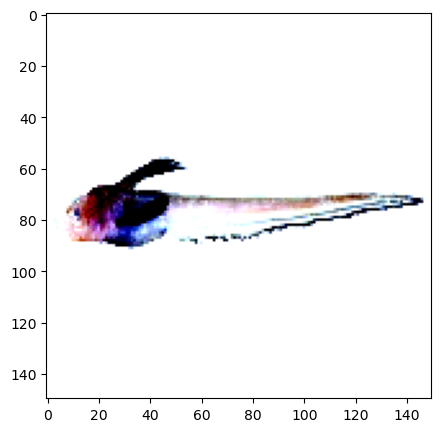

In [7]:
# Display an image from the training dataset to show that we are getting what we expect
[imgs,labels] = (next(iter(dataloader)))
imgs = np.squeeze(imgs)
plt.figure(figsize=(5,5))
plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())

In [8]:
train_dataset = ReadDataCSV("train_data.csv",transform=img_transform)
test_dataset = ReadDataCSV("test_data.csv",transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms

# Check if CUDA is available
CUDA = torch.cuda.is_available()

# Define VGG-19 model
model = models.vgg19(pretrained=True)
num_features = model.classifier[6].in_features
# Replace the last fully connected layer with a new one for 290 classes
model.classifier[6] = nn.Linear(num_features, 290)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

accuracy_values = []
epoch_number = []

# Move model to GPU if available
if CUDA:
    model.cuda()

# Train the VGG-19 CNN using the test database
for epoch in range(25):  # loop over the dataset multiple times (25 epochs)
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader, 0):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs = inputs.cpu()
            labels = labels.cpu()

        optimizer.zero_grad()  # zero the parameter gradients

        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # calculate the loss
        loss.backward()  # backward pass
        optimizer.step()  # optimize

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[epoch %d, itr %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    correct = 0
    total = 0

    # Test the VGG-19 CNN model on the test database
    with torch.no_grad():
        for images, labels in test_dataloader:
            if CUDA:
                images = images.cuda()
                labels = labels.cuda()
            else:
                images = images.cpu()
                labels = labels.cpu()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        epoch_number.append(epoch + 1)
        accuracy_values.append(test_accuracy)
        print('Epoch=%d Test Accuracy=%.3f' % (epoch + 1, test_accuracy))

print('Finished Training')
torch.cuda.empty_cache()  

c:\Users\arham\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arham\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch=1 Test Accuracy=43.820
Epoch=2 Test Accuracy=47.753
Epoch=3 Test Accuracy=48.876
Epoch=4 Test Accuracy=46.067
Epoch=5 Test Accuracy=61.798
Epoch=6 Test Accuracy=53.933
Epoch=7 Test Accuracy=60.674
Epoch=8 Test Accuracy=73.034
Epoch=9 Test Accuracy=76.404
Epoch=10 Test Accuracy=72.472
Epoch=11 Test Accuracy=76.966
Epoch=12 Test Accuracy=73.596
Epoch=13 Test Accuracy=77.528
Epoch=14 Test Accuracy=77.528
Epoch=15 Test Accuracy=74.719
Epoch=16 Test Accuracy=76.966
Epoch=17 Test Accuracy=78.652
Epoch=18 Test Accuracy=79.775
Epoch=19 Test Accuracy=80.337
Epoch=20 Test Accuracy=81.461
Epoch=21 Test Accuracy=82.022
Epoch=22 Test Accuracy=80.337
Epoch=23 Test Accuracy=81.461
Epoch=24 Test Accuracy=83.146
Epoch=25 Test Accuracy=78.652
Finished Training


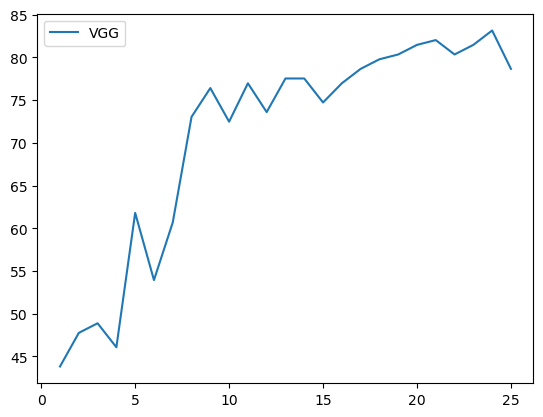

In [10]:
import matplotlib.pyplot as plt

plt.plot(epoch_number, accuracy_values, label="VGG")
plt.legend()
plt.show()